# imports

In [1]:
import pandas as pd
import numpy as np
from itables import show

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.metrics import roc_auc_score, classification_report


# prepare data

In [ ]:
# load
df = pd.read_csv('../fraud_encoded.csv')

show(df.head())
print(df.columns)

Loading ITables v2.5.2 from the internet... (need help?)


Index(['id', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'trans_date', 'trans_time', 'trans_time_group', 'trans_month',
       'trans_dayOfWeek', 'age', 'weekday_num', 'gender_M'],
      dtype='object')


In [ ]:
# prepare 
X = df.drop(columns=['is_fraud', 
                     'dob', # drop date of birth of customer (we have age)
                     'trans_date', 'trans_time', 'trans_dayOfWeek', 'trans_month', # drop 'duplicated' cols
                     'first', 'last', 'street', # drop names of customers
                     'trans_num', 'id']) # drop ids of transaction
y = df['is_fraud']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)

# scale
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[['amt', 'city_pop', 'merch_lat', 'merch_long']] = scaler.fit_transform(X_train[['amt', 'city_pop', 'merch_lat', 'merch_long']])
X_test_scaled = X_test.copy()
X_test_scaled[['amt', 'city_pop', 'merch_lat', 'merch_long']] = scaler.transform(X_test[['amt', 'city_pop', 'merch_lat', 'merch_long']])


# run log regression

In [ ]:
# basic log regression
log_reg = LogisticRegression(class_weight='balanced', # tells the model to create balanced weights
                             max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# eval
print("="*50)
print("MODEL PERFORMANCE")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}\n")
print(classification_report(y_test, y_pred))

# print coefficients 
print("\n" + "="*50)
print("FEATURE COEFFICIENTS")
print("="*50)

coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(coefficients.to_string(index=False))

print("\n" + "="*50)
print("TOP 10 FRAUD INDICATORS (Positive coefficients)")
print("="*50)
print(coefficients.head(10).to_string(index=False))

print("\n" + "="*50)
print("TOP 10 LEGITIMATE INDICATORS (Negative coefficients)")
print("="*50)
print(coefficients.tail(10).to_string(index=False))

MODEL PERFORMANCE
ROC-AUC: 0.5420

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.00      0.00      0.00       426

    accuracy                           1.00    111144
   macro avg       0.50      0.50      0.50    111144
weighted avg       0.99      1.00      0.99    111144


FEATURE COEFFICIENTS
         feature   coefficient
          cc_num -1.270708e-20
       unix_time  2.876554e-30
             zip -7.074923e-34
            city  1.265575e-35
             job -9.069813e-36
        merchant -3.682395e-36
             amt  3.214891e-36
             age  2.244127e-36
           state -1.622073e-36
trans_time_group  1.271667e-36
        category  1.116047e-36
            long -6.966245e-37
             lat  5.733905e-37
     weekday_num  4.071666e-37
       merch_lat  9.009728e-38
        city_pop -8.433059e-38
      merch_long -3.342439e-38
        gender_M -6.533449e-39

TOP 10 FRAUD INDICATORS (P

c:\Users\halou\Documents\GitHub\doing_data_science\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\halou\Documents\GitHub\doing_data_science\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\halou\Documents\GitHub\doing_data_science\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [ ]:
# complicated, have to revise

log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)

rfecv = RFECV(
    estimator=log_reg,
    step=1,                    # Remove 1 feature at a time
    cv=5,                      # 5-fold cross-validation
    scoring='roc_auc',         # Optimize for ROC-AUC
    n_jobs=-1,                 # Use all CPU cores
    verbose=1                  # Show progress
)

rfecv.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X.columns[rfecv.support_].tolist()
n_selected = rfecv.n_features_

print(f"\nOptimal number of features: {n_selected}")
print(f"Selected features: {selected_features}")

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.

Optimal number of features: 1
Selected features: ['cc_num']


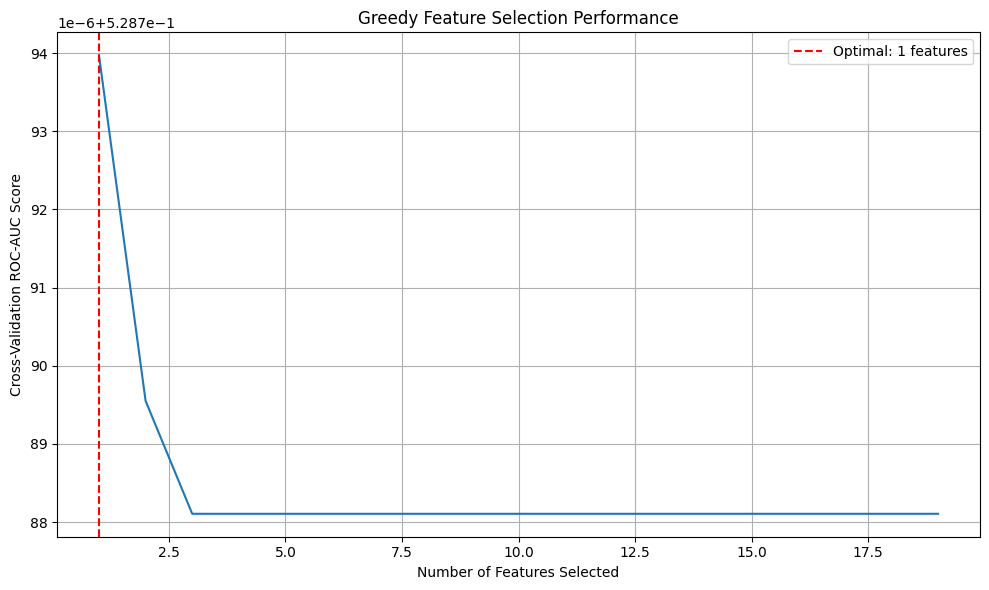

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation ROC-AUC Score')
plt.title('Greedy Feature Selection Performance')
plt.axvline(x=n_selected, color='r', linestyle='--', 
            label=f'Optimal: {n_selected} features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()